In [1]:
using LinearAlgebra

In [2]:
using Plots
using LaTeXStrings #Latex Syntax for Plotting

In [3]:
using ITensors
# ITensors.compile()

In [4]:
using DelimitedFiles #Save .txt

Article: https://arxiv.org/abs/cond-mat/0409692

$$ H = \sum_{j = 1}^{N - 1} J_{n} ( S_{j}^{x}S_{j+1}^{x} + S_{j}^{y}S_{j+1}^{y} + J_{z} S_{j}^{z}S_{j+1}^{z} )$$

Dimerized Model when $J_{z} = const$ and $J_{n} = [1 + (-1)^n \delta]$

**XX Model when $J_{z} = \delta = 0 \Rightarrow J_{n} = 1$**

In [5]:
function Create_MPO(N, Jn, Jz) # Make N S=1/2 spin indices 
    sites = siteinds("S=1/2",N) 
    # Input the operator terms 
    
    os = OpSum() 
    for i=1:N-1 
        os += Jn,"Sx",i,"Sx",i+1 
        os += Jn,"Sy",i,"Sy",i+1 
        os += Jn*Jz,"Sz",i,"Sz",i+1 
    end 
    
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

Create_MPO (generic function with 1 method)

In [6]:
N = 100

H, sites = Create_MPO(100, 1, 2)

(MPO
[1] ((dim=5|id=403|"Link,l=1"), (dim=2|id=295|"S=1/2,Site,n=1")', (dim=2|id=295|"S=1/2,Site,n=1"))
[2] ((dim=5|id=403|"Link,l=1"), (dim=5|id=180|"Link,l=2"), (dim=2|id=393|"S=1/2,Site,n=2")', (dim=2|id=393|"S=1/2,Site,n=2"))
[3] ((dim=5|id=180|"Link,l=2"), (dim=5|id=478|"Link,l=3"), (dim=2|id=111|"S=1/2,Site,n=3")', (dim=2|id=111|"S=1/2,Site,n=3"))
[4] ((dim=5|id=478|"Link,l=3"), (dim=5|id=434|"Link,l=4"), (dim=2|id=625|"S=1/2,Site,n=4")', (dim=2|id=625|"S=1/2,Site,n=4"))
[5] ((dim=5|id=434|"Link,l=4"), (dim=5|id=206|"Link,l=5"), (dim=2|id=614|"S=1/2,Site,n=5")', (dim=2|id=614|"S=1/2,Site,n=5"))
[6] ((dim=5|id=206|"Link,l=5"), (dim=5|id=248|"Link,l=6"), (dim=2|id=43|"S=1/2,Site,n=6")', (dim=2|id=43|"S=1/2,Site,n=6"))
[7] ((dim=5|id=248|"Link,l=6"), (dim=5|id=662|"Link,l=7"), (dim=2|id=631|"S=1/2,Site,n=7")', (dim=2|id=631|"S=1/2,Site,n=7"))
[8] ((dim=5|id=662|"Link,l=7"), (dim=5|id=820|"Link,l=8"), (dim=2|id=984|"S=1/2,Site,n=8")', (dim=2|id=984|"S=1/2,Site,n=8"))
[9] ((dim=5|id=8

$$ | init \rangle = |\uparrow \uparrow  ... \downarrow \downarrow \rangle$$

In [7]:
Psi_0 = MPS(sites, n -> n <= N/2 ? "Up" : "Dn") #If  n <= N/2 then "Up", else "Dn"

MPS
[1] ((dim=2|id=295|"S=1/2,Site,n=1"), (dim=1|id=76|"Link,l=1"))
[2] ((dim=1|id=76|"Link,l=1"), (dim=2|id=393|"S=1/2,Site,n=2"), (dim=1|id=395|"Link,l=2"))
[3] ((dim=1|id=395|"Link,l=2"), (dim=2|id=111|"S=1/2,Site,n=3"), (dim=1|id=304|"Link,l=3"))
[4] ((dim=1|id=304|"Link,l=3"), (dim=2|id=625|"S=1/2,Site,n=4"), (dim=1|id=176|"Link,l=4"))
[5] ((dim=1|id=176|"Link,l=4"), (dim=2|id=614|"S=1/2,Site,n=5"), (dim=1|id=778|"Link,l=5"))
[6] ((dim=1|id=778|"Link,l=5"), (dim=2|id=43|"S=1/2,Site,n=6"), (dim=1|id=880|"Link,l=6"))
[7] ((dim=1|id=880|"Link,l=6"), (dim=2|id=631|"S=1/2,Site,n=7"), (dim=1|id=725|"Link,l=7"))
[8] ((dim=1|id=725|"Link,l=7"), (dim=2|id=984|"S=1/2,Site,n=8"), (dim=1|id=425|"Link,l=8"))
[9] ((dim=1|id=425|"Link,l=8"), (dim=2|id=24|"S=1/2,Site,n=9"), (dim=1|id=383|"Link,l=9"))
[10] ((dim=1|id=383|"Link,l=9"), (dim=2|id=395|"S=1/2,Site,n=10"), (dim=1|id=734|"Link,l=10"))
[11] ((dim=1|id=734|"Link,l=10"), (dim=2|id=457|"S=1/2,Site,n=11"), (dim=1|id=851|"Link,l=11"))
[12] ((d

In [8]:
function TEBD_Time_Evolution_Expected_Value_Sz(t, Psi_0, Jn, Jz, site_inds)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    N = length(Psi_0)
    
    cutoff = 1E-11 #the cutoff value for truncating the density matrix eigenvalues. https://itensor.github.io/ITensors.jl/dev/ContractionSequenceOptimization.html#NDTensors.contract
    dt = 0.1
    
    s = site_inds
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
        
        s1 = s[j]
        s2 = s[j + 1]
        hj = Jn*Jz*op("Sz", s1)*op("Sz", s2) + Jn*op("Sx", s1)*op("Sx", s2) + Jn*op("Sy", s1)*op("Sy", s2)
        
    U = exp(-im * dt/ 2 * hj)
    push!(Evolution_Gates, U)
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Psi_t = Psi_0
    
    Expected_Values = zeros((N, trunc(Int, t/dt) + 1)) #Each column contain the expected value of Sz for all sites for time = ncolum*(dt - 1)
    Expected_Values[:, 1] = expect(Psi_t,"Sz")    
    Times = [0.0]
    
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff)
        normalize!(Psi_t)

        Expected_Values[:, trunc(Int, time/dt + 1)] = expect(Psi_t,"Sz")
        append!(Times, time)
    end
    
    return Expected_Values, Times

    # Psi_t = Psi_0
    
    # Amplitudes = [abs(inner(Psi_t, Psi_0))]
    # Times = [0.0]
    
    # for time in dt:dt:t
    #     Psi_t = apply(Evolution_Gates, Psi_t; cutoff)
    #     normalize!(Psi_t)
        
    #     append!(Amplitudes, abs(inner(Psi_t, Psi_0)))
    #     append!(Times, time)
    # end
    
    # return Amplitudes, Times
    
end

TEBD_Time_Evolution_Expected_Value_Sz (generic function with 1 method)

In [9]:
N = 200

H_XX, sites = Create_MPO(N, 1, 0) #XX Model
Psi_0 = MPS(sites, n -> n <= N/2 ? "Up" : "Dn") #If  n <= N/2 then "Up", else "Dn"

T = 70

@time begin
# Expected_Values, Times = TEBD_Time_Evolution_Expected_Value_Sz(T, Psi_0, 1, 0, sites)
end

  0.000000 seconds


In [10]:
# writedlm("Expected_Values.txt", Expected_Values) 

In [11]:
Expected_Values = readdlm("Expected_Values_0_01.txt")
Times = 0:0.01:70

0.0:0.01:70.0

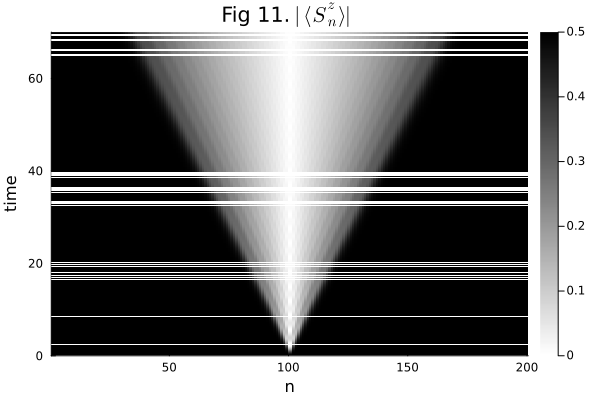

In [12]:
heatmap(1:N, Times, abs.(transpose(Expected_Values)), c=cgrad([:white, :black]), xlabel="n", ylabel="time", title= "Fig 11. "*L"| \langle S^{z}_{n} \rangle |") #x, y, 
# savefig("Fig11_Cutoff_10e-11_dt0_005.pdf")    

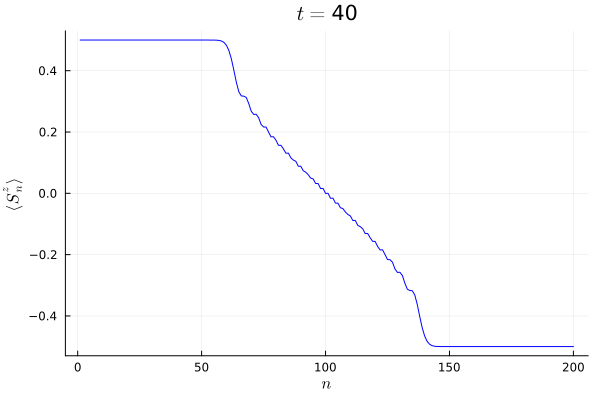

In [13]:
time = 40

plot(1:N, Expected_Values[:, trunc(Int, time/0.01 + 1)], color = "blue", label = false)

xlabel!(L"n")
ylabel!(L"\langle S^{z}_{n} \rangle")
title!(L"t = "*string(time))

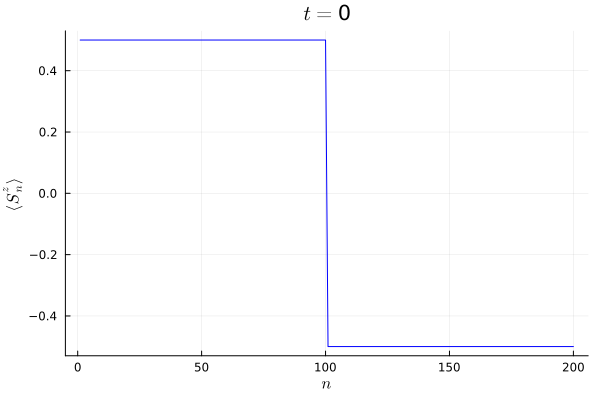

In [14]:
time = 0

plot(1:N, Expected_Values[:, trunc(Int, time/0.01 + 1)], color = "blue", label = false)

xlabel!(L"n")
ylabel!(L"\langle S^{z}_{n} \rangle")
title!(L"t = "*string(time))

Useful Links:

https://itensor.github.io/ITensors.jl/stable/search.html?q=observer

https://itensor.github.io/ITensors.jl/stable/examples/ITensor.html#Tracing-an-ITensor

https://itensor.discourse.group/t/two-site-reduced-density-matrix/719

http://itensor.org/docs.cgi?page=formulas/mps_two_rdm&vers=cppv2

https://itensor.github.io/ITensors.jl/stable/MPSandMPO.html#Algebra-Operations

https://itensor.github.io/ITensors.jl/stable/DMRGObserver.html#ITensors.DMRGObserver-Tuple{Vector{String},%20Vector{%3C:Index}}

https://itensor.github.io/ITensors.jl/stable/MPSandMPO.html#ITensors.projector-Tuple{MPS} #Outer method

https://itensor.discourse.group/t/trace-and-partial-trace-of-mpo/79

